In [64]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

贝叶斯网络结构:


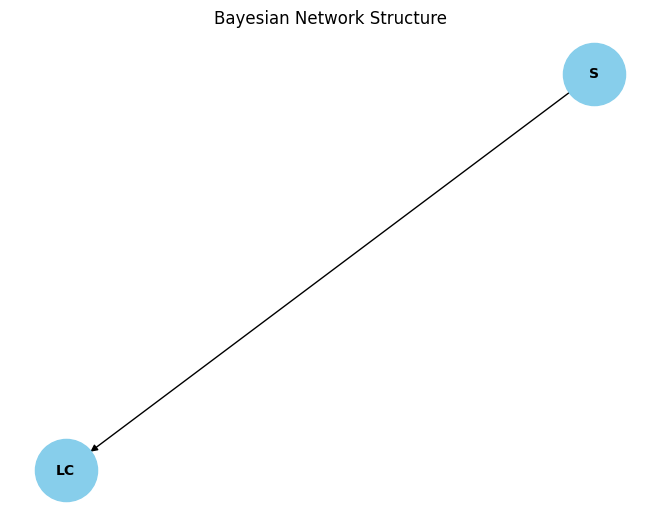


Conditional Probability Tables:

Variable: S
  P(S=0) = 0.8000
  P(S=1) = 0.2000

Variable: LC
  P(LC=0 | S=0) = 0.9900
  P(LC=1 | S=0) = 0.0100
  P(LC=0 | S=1) = 0.9000
  P(LC=1 | S=1) = 0.1000

推理: P(S=1 | LC=1)
采样推理结果: P(S=0 | LC=1) = 0.2855, P(S=1 | LC=1) = 0.7145
理论计算结果: P(S=1 | LC=1) ≈ 0.7143


In [ ]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx


class BayesianNetwork:
    """传统贝叶斯网络实现"""

    def __init__(self):
        self.graph = nx.DiGraph()  # 有向无环图
        self.cpts = {}  # 条件概率表
        self.variables = []  # 网络中的变量
        self.parents = defaultdict(list)  # 每个变量的父节点

    def add_node(self, variable, cpt=None):
        """添加节点到网络"""
        if variable not in self.variables:
            self.variables.append(variable)
            self.graph.add_node(variable)
            if cpt is not None:
                self.set_cpt(variable, cpt)

    def add_edge(self, parent, child):
        """添加边（表示依赖关系）"""
        if parent not in self.variables:
            self.add_node(parent)
        if child not in self.variables:
            self.add_node(child)

        self.graph.add_edge(parent, child)
        self.parents[child].append(parent)
        self.parents[child].sort()  # 保持顺序一致

    def set_cpt(self, variable, cpt):
        """设置条件概率表"""
        if variable not in self.variables:
            self.add_node(variable)

        # 验证CPT格式
        parents = self.parents[variable]
        expected_shape = tuple(2 for _ in range(len(parents) + 1))
        if cpt.shape != expected_shape:
            raise ValueError(
                f"CPT shape mismatch. Expected {expected_shape}, got {cpt.shape}"
            )

        self.cpts[variable] = cpt

    def joint_probability(self, state):
        """计算联合概率 P(X1, X2, ..., Xn)"""
        prob = 1.0
        topo_order = list(nx.topological_sort(self.graph))  # 按拓扑顺序计算
        for variable in topo_order:
            # 获取变量状态 (0 或 1)
            var_state = state[variable]

            # 获取父节点状态
            parent_states = tuple(state[parent] for parent in self.parents[variable])

            # 从CPT获取概率
            if parent_states:
                prob *= self.cpts[variable][parent_states + (var_state,)]
            else:
                prob *= self.cpts[variable][var_state]

        return prob

    def get_probability(self, variable, value, parent_states):
        """获取条件概率 P(variable=value | parent_states)"""
        if parent_states:
            return self.cpts[variable][parent_states + (value,)]
        else:
            return self.cpts[variable][value]

    def infer(self, query, evidence=None, n_samples=100000):
        """使用似然加权采样进行推理"""
        np.random.seed(42)
        if evidence is None:
            evidence = {}

        # 检查查询变量是否在证据中
        if query in evidence:
            return {evidence[query]: 1.0}

        # 获取拓扑排序
        topo_order = list(nx.topological_sort(self.graph))

        counts = {0: 0, 1: 0}  # 直接计数
        total_weight = 0.0

        for _ in range(n_samples):
            sample = {}
            weight = 1.0

            # 向前传递：生成样本
            for var in topo_order:
                parents = self.parents[var]
                parent_states = tuple(sample[parent] for parent in parents)

                # 如果是证据变量
                if var in evidence:
                    observed_value = evidence[var]
                    sample[var] = observed_value
                    # 更新权重
                    prob = self.get_probability(var, observed_value, parent_states)
                    weight *= prob
                else:
                    # 非证据变量：采样
                    prob = self.get_probability(var, 1, parent_states)
                    sample[var] = 1 if np.random.rand() < prob else 0

            # 更新计数（只考虑查询变量）
            if query not in evidence:  # 确保查询变量不是证据
                counts[sample[query]] += weight
                total_weight += weight

        # 归一化
        if total_weight > 0:
            distribution = {0: counts[0] / total_weight, 1: counts[1] / total_weight}
        else:
            distribution = {0: 0.5, 1: 0.5}  # 避免除零错误

        return distribution

    def visualize(self):
        """可视化网络"""
        pos = nx.spring_layout(self.graph)
        nx.draw(
            self.graph,
            pos,
            with_labels=True,
            node_size=2000,
            node_color="skyblue",
            font_size=10,
            font_weight="bold",
        )
        plt.title("Bayesian Network Structure")
        plt.show()

        # 打印CPT
        print("\nConditional Probability Tables:")
        for variable in self.variables:
            print(f"\nVariable: {variable}")
            parents = self.parents[variable]

            if not parents:
                print(f"  P({variable}=0) = {self.cpts[variable][0]:.4f}")
                print(f"  P({variable}=1) = {self.cpts[variable][1]:.4f}")
            else:
                # 生成所有可能的父节点组合
                parent_combinations = []
                for i in range(2 ** len(parents)):
                    combination = []
                    for j in range(len(parents)):
                        combination.append((i >> j) & 1)
                    parent_combinations.append(tuple(combination))

                for comb in parent_combinations:
                    # 创建父节点状态字符串
                    parent_str = ", ".join(
                        f"{parents[i]}={val}" for i, val in enumerate(comb)
                    )

                    # 打印条件概率
                    print(
                        f"  P({variable}=0 | {parent_str}) = {self.cpts[variable][comb + (0,)]:.4f}"
                    )
                    print(
                        f"  P({variable}=1 | {parent_str}) = {self.cpts[variable][comb + (1,)]:.4f}"
                    )

In [ ]:
# ======================
# 示例：吸烟与肺癌的贝叶斯网络
# ======================

# 创建贝叶斯网络
bn = BayesianNetwork()

# 添加节点（变量）
# 吸烟(S): 0=不吸烟, 1=吸烟
# 肺癌(LC): 0=没有肺癌, 1=有肺癌
bn.add_node("S")
bn.add_node("LC")

# 添加边（依赖关系）
bn.add_edge("S", "LC")  # 吸烟影响肺癌

# 设置条件概率表（CPT）
# P(S=1) = 0.2
bn.set_cpt("S", np.array([0.8, 0.2]))  # [P(S=0), P(S=1)]

# P(LC=1 | S=0) = 0.01
# P(LC=1 | S=1) = 0.1
bn.set_cpt(
    "LC",
    np.array(
        [
            [0.99, 0.01],  # S=0 时: [P(LC=0|S=0), P(LC=1|S=0)]
            [0.90, 0.10],  # S=1 时: [P(LC=0|S=1), P(LC=1|S=1)]
        ]
    ),
)

# 可视化网络
print("贝叶斯网络结构:")
bn.visualize()

# 推理示例：P(S=1 | LC=1)
print("\n推理: P(S=1 | LC=1)")
distribution = bn.infer("S", evidence={"LC": 1}, n_samples=100000)

# 理论计算（用于验证）
# P(S=1 | LC=1) = P(LC=1 | S=1)P(S=1) / P(LC=1)
# P(LC=1) = P(LC=1|S=0)P(S=0) + P(LC=1|S=1)P(S=1)
#          = 0.01*0.8 + 0.1*0.2 = 0.008 + 0.02 = 0.028
# P(S=1|LC=1) = (0.1 * 0.2) / 0.028 ≈ 0.7143

print(
    f"采样推理结果: P(S=0 | LC=1) = {distribution[0]:.4f}, P(S=1 | LC=1) = {distribution[1]:.4f}"
)
print(f"理论计算结果: P(S=1 | LC=1) ≈ 0.7143")